# Correcting bit-flips errors

This notebook implements the quantum circuit to recover a qubit from bit-flip errors

## Importing needed modules

In [30]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info.states import Statevector

## Three qubit encoding

Because of the no cloning theorem we cannot copy a qubit to add redundancy like we would do in classical computing. What we can do instead is implementing the following encoding:<br><br>
<center>
$|\psi\rangle =  \alpha|0\rangle + \beta|1\rangle \rightarrow \alpha|000\rangle + \beta|111\rangle$
</center>


## Inizializing the circuit

For the circuit we need three qubits for the econding and two auxiliary qubits that will be used to detect if the bit flip occured and in which qubit.

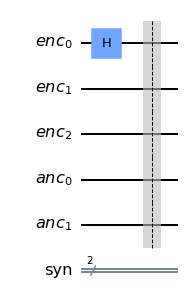

In [31]:
q_enc = QuantumRegister(3, "enc")
q_anc = QuantumRegister(2, "anc")
c_syn = ClassicalRegister(2, "syn")

qc = QuantumCircuit(q_enc, q_anc, c_syn)
qc.h(q_enc[0])
qc.barrier()
qc.draw(output="mpl")

## Implementing the encoding

The first qubit is the qubit we want to encode is in the first qubit. The initial state is:<br><br>
$(\alpha|0\rangle + \beta|1\rangle)|0\rangle|0\rangle =  \alpha|000\rangle + \beta|100\rangle$
<br><br>
After the first CNOT gate it becomes:<br><br>
$\alpha|000\rangle + \beta|110\rangle$
<br><br>
After the second CNOT gate it becomes:<br><br>
$\alpha|000\rangle + \beta|111\rangle$
<br><br>
which is the encoding we wanted.


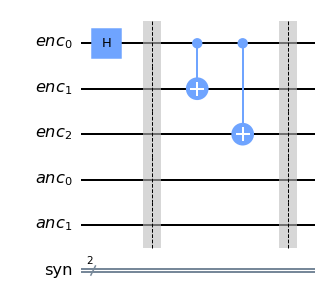

In [32]:
qc.cx(q_enc[0], q_enc[1])
qc.cx(q_enc[0], q_enc[2])

qc.barrier()

qc.draw(output="mpl")

## Simulate the bit flip error

We simulate a bit flip error by adding a $X$ gate on the second qubit

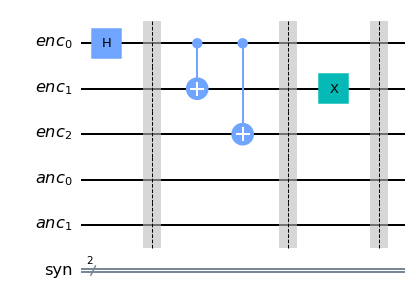

In [33]:
qc.x(q_enc[1])
qc.barrier()

qc.draw(output="mpl")

## Implementing the error detecting-correcting circuit

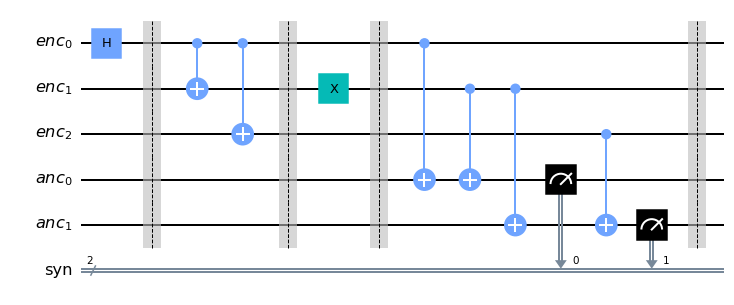

In [34]:
qc.cx(q_enc[0], q_anc[0])
qc.cx(q_enc[1], q_anc[0])
qc.cx(q_enc[1], q_anc[1])
qc.cx(q_enc[2], q_anc[1])

qc.measure(q_anc[0], c_syn[0])
qc.measure(q_anc[1], c_syn[1])
qc.barrier()
qc.draw("mpl")

## Recovery circuit

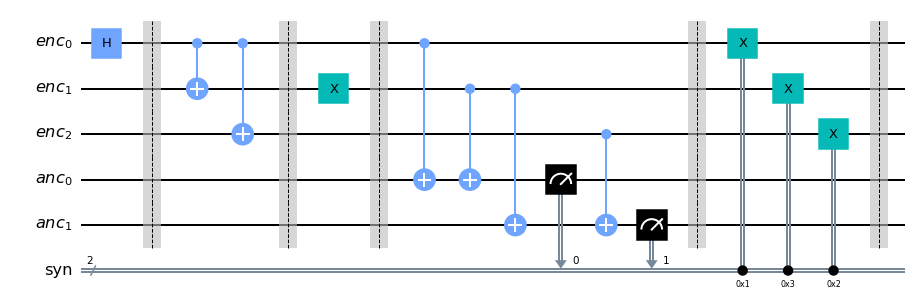

In [35]:
# correction based on the syndrome
# the first bit if flip if the f
qc.x(q_enc[0]).c_if(c_syn, 1)
qc.x(q_enc[1]).c_if(c_syn, 3)
qc.x(q_enc[2]).c_if(c_syn, 2)
qc.barrier()

qc.draw("mpl")

## Decoding circuit

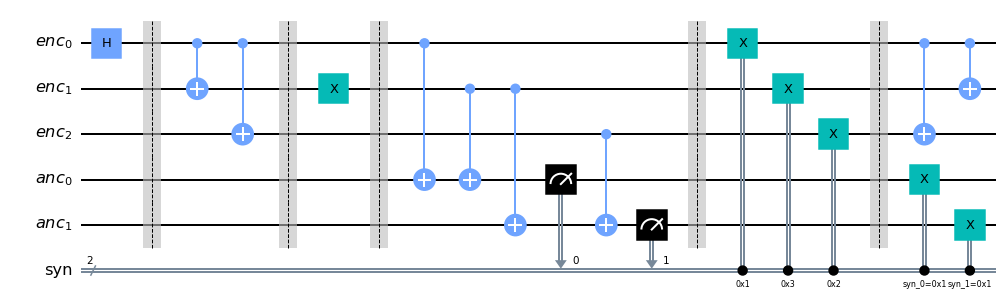

In [36]:
qc.cx(q_enc[0], q_enc[2])
qc.cx(q_enc[0], q_enc[1])

# set ancillary qubits to 0
qc.x(q_anc[0]).c_if(c_syn[0], 1)
qc.x(q_anc[1]).c_if(c_syn[1], 1)

qc.draw("mpl")

## Executing the circuit

In [37]:
backend = Aer.get_backend('statevector_simulator')
job = backend.run(qc)
result = job.result()
outputstate = result.get_statevector(qc, decimals=3)
# print(outputstate)
alpha = outputstate[0]
beta = outputstate[1]

simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=1000)
syndrome = job.result().get_counts(qc)
print(f"Syndrome qubits: {list(syndrome.keys())[0][::-1]}")
print(f"Decoded state:\n{alpha}|0> + {beta}|1>")

Syndrome qubits: 11
Decoded state:
(0.707+0j)|0> + (0.707+0j)|1>


## Defining a test function

In [42]:
def circuit(input_qubit, error_mask):
    
    # initialization
    q_enc = QuantumRegister(3, "enc")
    q_anc = QuantumRegister(2, "anc")
    c_syn = ClassicalRegister(2, "syn")
    
    qc = QuantumCircuit(q_enc, q_anc, c_syn)
    qc.h(q_enc[0])
    qc.barrier()
    
    
    # encoding 
    qc.cx(q_enc[0], q_enc[1])
    qc.cx(q_enc[0], q_enc[2])
    qc.barrier()

    # error
    if error_mask[0] == 1:
        qc.x(q_enc[0])
    if error_mask[1] == 1:
        qc.x(q_enc[1])
    if error_mask[2] == 1:
        qc.x(q_enc[2])
    
    qc.barrier() 
    
    # error syndrome
    qc.cx(q_enc[0], q_anc[0])
    qc.cx(q_enc[1], q_anc[0])
    qc.cx(q_enc[1], q_anc[1])
    qc.cx(q_enc[2], q_anc[1])

    qc.measure(q_anc[0], c_syn[0])
    qc.measure(q_anc[1], c_syn[1])
    qc.barrier()
    
    # recovery
    qc.x(q_enc[0]).c_if(c_syn, 1)
    qc.x(q_enc[1]).c_if(c_syn, 3)
    qc.x(q_enc[2]).c_if(c_syn, 2)
    qc.barrier()
    
    # decoding
    qc.cx(q_enc[0], q_enc[2])
    qc.cx(q_enc[0], q_enc[1])
    
    # set ancillary qubits to 0
    qc.x(q_anc[0]).c_if(c_syn[0], 1)
    qc.x(q_anc[1]).c_if(c_syn[1], 1)
    
    # get state vector    
    backend = Aer.get_backend('statevector_simulator')
    job = backend.run(qc)
    result = job.result()
    outputstate = result.get_statevector(qc, decimals=3)
    alpha = outputstate[0]
    beta = outputstate[1]

    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=1000)
    syndrome = job.result().get_counts(qc)
    
    return alpha, beta, syndrome, qc

Syndrome qubits: 01
Decoded state:
(0.707+0j)|0> + (0.707+0j)|1>


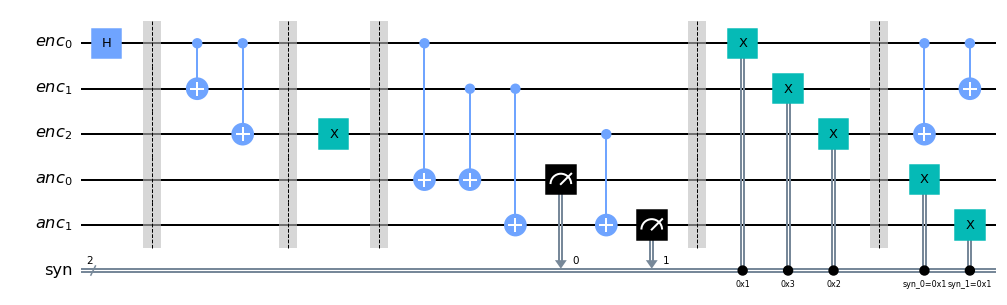

In [47]:
alpha, beta, syndrome, qc = circuit(0, (0,0,1))
print(f"Syndrome qubits: {list(syndrome.keys())[0][::-1]}")
print(f"Decoded state:\n{alpha}|0> + {beta}|1>")
qc.draw("mpl")